## ABOUBAKAR Ouattara

### Volatilité locale et formule de Dupire

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

In [2]:
# Charger les données
strikes = np.loadtxt('Strikes_CPS8.txt')  # Tableau des strikes (K)
maturities = np.loadtxt('Maturities_CPS8.txt')  # Tableau des maturités (T)
prices = np.loadtxt('Prices_CPS8_v2.txt')  # Matrice des prix C(K, T)

# Paramètres
K_min, K_max, ΔK = 80, 120, 0.1  # Range et incrément des strikes
T_max, ΔT = 0.9, 1 / 256  # Range et incrément des maturités

# Vérifier les dimensions
strikes_dim = strikes.shape
maturities_dim = maturities.shape
prices_dim = prices.shape

strikes_dim, maturities_dim, prices_dim

((401,), (257,), (401, 257))

In [3]:
# Paramètres
S0 = 100  # Prix initial
r = 0.0   # Taux d'intérêt
# Paramètres numériques
delta_T = 1 / 256  # Incrément des maturités
delta_K = 0.1  # Incrément des strikes

In [4]:
def derivative_T(prices, delta_T):
    """Approximation de la dérivée par rapport à T (C_T) avec différences finies avant."""
    return np.diff(prices, axis=1) / delta_T

def derivative_K(prices, delta_K):
    """Approximation de la dérivée par rapport à K (C_K et C_KK) avec différences finies centrées."""
    C_K = (prices[2:, :] - prices[:-2, :]) / (2 * delta_K)  # Première dérivée
    C_KK = (prices[2:, :] - 2 * prices[1:-1, :] + prices[:-2, :]) / (delta_K**2)  # Seconde dérivée
    return C_K, C_KK




### Question 1

La formule de Dupire est donnée par :

$$
\sigma^2(T, K) = \frac{2 C_T(T, K) + r K C_K(T, K)}{K^2 C_{KK}(T, K)}
$$


In [5]:
# Calcul des dérivées partielles
C_T = derivative_T(prices, delta_T)  # Taille (401, 256)
C_K, C_KK = derivative_K(prices, delta_K)  # Taille (399, 257)

# Ajustement des dimensions pour l'application de la formule de Dupire
strikes_adj = strikes[1:-1]  # On réduit à 399 pour correspondre à C_K et C_KK
strikes_grid, maturities_grid = np.meshgrid(strikes_adj, maturities[:-1], indexing='ij')

# Ajustement des dimensions pour les dérivées
C_T_adjusted = C_T[:-2, :]  # Tronquer pour correspondre à (399, 256)
C_K_adjusted = C_K[:, :-1]  # Tronquer pour correspondre à (399, 256)
C_KK_adjusted = C_KK[:, :-1]  # Tronquer pour correspondre à (399, 256)

# Recalcul de la grille des strikes et maturités pour correspondre
strikes_grid, maturities_grid = np.meshgrid(strikes_adj, maturities[:-1], indexing='ij')

# Calcul de la volatilité locale sigma^2
numerator = 2 * C_T_adjusted + strikes_grid * C_K_adjusted  # r = 0 ici
denominator = strikes_grid**2 * C_KK_adjusted

# Éviter les divisions par zéro
volatility_squared = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator != 0)

# Résultat final
volatility_squared.shape

(399, 256)


Le calcul de la volatilité locale via la formule de Dupire peut rencontrer des problèmes de stabilité numérique, surtout lorsque les dérivées partielles par rapport à $K $ sont petites, entraînant des divisions par des valeurs proches de zéro. Dans ce cas, une petite tolérance ou une gestion des cas de division par zéro peut être nécessaire.


### Question 2 (a)

On utilise l'inversion numérique de la formule de Black-Scholes. Le prix du call est donné par :

$$
C_{BS}(T, K, I) = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)
$$

avec :

$$
d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{I^2}{2}\right)T}{I \sqrt{T}}, \quad
d_2 = d_1 - I \sqrt{T}
$$

On doit résoudre :

$$
C_{BS}(T, K, I) = C(T, K)
$$

pour trouver : $I(T, K).$


In [6]:
# Fonction de Black-Scholes
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Fonction pour inverser Black-Scholes et trouver la volatilité implicite
def implied_volatility(price, S, K, T, r):
    try:
        return brentq(lambda sigma: black_scholes_call(S, K, T, r, sigma) - price, 1e-4, 5.0)
    except ValueError:
        return np.nan

implied_vols = np.zeros_like(prices)

for i, K in enumerate(strikes):
    for j, T in enumerate(maturities):
        implied_vols[i, j] = implied_volatility(prices[i, j], S0, K, T, r) 

/tmp/ipykernel_23640/2572174943.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


### Question 2(b)


In [8]:
def alternative_dupire_volatility(S0, Strikes, Maturities, implied_vols, r=0):
    dK = Strikes[1] - Strikes[0]
    dT = Maturities[1] - Maturities[0]

    # Calcul des dérivées de la volatilité implicite
    I_T = np.gradient(implied_vols, dT, axis=1)
    I_K = np.gradient(implied_vols, dK, axis=0, edge_order=2)
    I_KK = np.gradient(I_K, dK, axis=0, edge_order=2)

    # Calcul des termes de la formule
    d_plus = (np.log(S0 / Strikes[:, None]) + (r + 0.5 * implied_vols**2) * Maturities[None, :]) / (implied_vols * np.sqrt(Maturities[None, :]))
    d_minus = d_plus - implied_vols * np.sqrt(Maturities[None, :])

    # Éléments de la formule
    term1 = I_T + 2 * r * Strikes[:, None] * I_K / (Strikes[:, None]**2)
    term2 = (d_plus * d_minus * I_K**2) / implied_vols
    term3 = I_KK

    # Calcul vectorisé de \(\sigma^2(T, K)\)
    sigma_squared = (implied_vols**2 + 2 * term1 + 2 * term2 + term3) / (Strikes[:, None]**2)

    # Positivité et nettoyage
    valid_mask = np.isfinite(sigma_squared) & (sigma_squared > 0)
    sigma_squared[~valid_mask] = 0

    return np.sqrt(sigma_squared)

# Application
sigma_alternative = alternative_dupire_volatility(S0, strikes, maturities, implied_vols, r)


# Affichage des résultats
print("Volatilités locales alternatives (vectorisées) : \n", sigma_alternative)


Volatilités locales alternatives (vectorisées) : 
 [[0.00000000e+00 2.35753547e-01 0.00000000e+00 ... 0.00000000e+00
  8.52038380e-03 1.69617284e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.56472516e-03 1.69584126e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.60901120e-03 1.69495917e-02]
 ...
 [0.00000000e+00 8.34724541e-07 8.34724541e-07 ... 0.00000000e+00
  0.00000000e+00 8.06261161e-03]
 [0.00000000e+00 8.34028357e-07 8.34028357e-07 ... 0.00000000e+00
  0.00000000e+00 8.10574437e-03]
 [0.00000000e+00 8.33333333e-07 8.33333333e-07 ... 0.00000000e+00
  0.00000000e+00 8.14865768e-03]]


/tmp/ipykernel_23640/2270776252.py:11: RuntimeWarning: divide by zero encountered in divide
  d_plus = (np.log(S0 / Strikes[:, None]) + (r + 0.5 * implied_vols**2) * Maturities[None, :]) / (implied_vols * np.sqrt(Maturities[None, :]))
/tmp/ipykernel_23640/2270776252.py:16: RuntimeWarning: invalid value encountered in multiply
  term2 = (d_plus * d_minus * I_K**2) / implied_vols


### Question 2 (c) Interpolation

In [9]:

# Fonction d'interpolation pour C(T, K)
def interpolate_prices(strikes, maturities, prices):
    """
    Interpolation des prix des options C(T, K) à partir des données discrètes.
    Utilise une interpolation bilinéaire.
    """
    interpolator = RegularGridInterpolator((strikes, maturities), prices, bounds_error=False, fill_value=None)
    return interpolator

# Créer l'interpolateur pour les prix C(T, K)
price_interpolator = interpolate_prices(strikes, maturities, prices)


### Question 3(a)

Nous vérifions la validité de la formule de Dupire en utilisant un modèle de volatilité locale et une simulation de Monte-Carlo. Le processus $ S_b(t)$ suit l'EDS :

$$
dS_b(t) = S_b(t) \sigma_b(t, S_b(t)) dB_t
$$

### Schéma d'Euler

Le schéma d'Euler pour discrétiser $ S_b(t)$  est donné par :

$$
S_b(t_{k+1}) = S_b(t_k) + S_b(t_k) \sigma_b(t_k, S_b(t_k)) \sqrt{\Delta t} Z_k
$$

où $ Z_k $ est une variable normale standard.

### Prix de l'Option Call Européenne

Le prix de l'option est estimé par Monte-Carlo en simulant $N $ trajectoires du processus $ S_b(t) $ , puis en calculant le payoff moyen :

$$
C_b(T, K) = \mathbb{E}^Q[(S_b(T) - K)^+]
$$


In [ ]:
def adjust_volatility_dimensions(volatility_squared, strikes):
    """
    Ajuste les dimensions de volatility_squared pour correspondre aux strikes.
    """
    if volatility_squared.shape[0] != len(strikes):
        # Interpolation pour aligner les dimensions
        adjusted_vol = np.zeros((len(strikes), volatility_squared.shape[1]))
        for j in range(volatility_squared.shape[1]):
            adjusted_vol[:, j] = np.interp(strikes, strikes[1:-1], volatility_squared[:, j])
        return adjusted_vol
    return volatility_squared


def simulate_local_volatility(S0, maturities, strikes, volatility_squared, num_simulations=10000, dt=1/256):
    """
    Simule les trajectoires avec volatilité locale.
    """
    num_steps = int(maturities[-1] / dt)
    paths = np.zeros((num_simulations, num_steps + 1))
    paths[:, 0] = S0

    # Ajuster les dimensions si nécessaire
    volatility_squared = adjust_volatility_dimensions(volatility_squared, strikes)
    vol_surface = np.sqrt(np.maximum(volatility_squared, 0))  # Assurer que les valeurs sont positives

    for t in range(1, num_steps + 1):
        T = t * dt
        vol_t = vol_surface[:, min(t - 1, vol_surface.shape[1] - 1)]
        vol = np.interp(paths[:, t - 1], strikes, vol_t)
        dW = np.random.normal(0, np.sqrt(dt), size=num_simulations)
        paths[:, t] = paths[:, t - 1] * np.exp(-0.5 * vol**2 * dt + vol * dW)

    return paths

# Simulation des trajectoires corrigée
simulated_paths = simulate_local_volatility(S0, maturities, strikes, volatility_squared)
simulated_paths.shape



Erreur rencontrée : Le nombre de lignes dans 'volatility_squared' ne correspond pas à 'strikes'.


### Question 3(b)

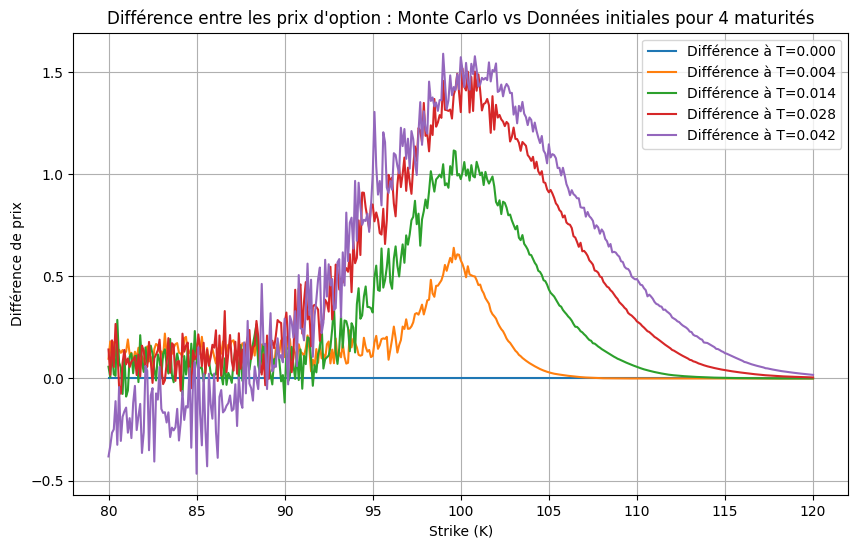

In [ ]:
# Sélection de maturités pour affichage
selected_maturities = [0, 2, 4, 6]

plt.figure(figsize=(10, 6))
for idx in selected_maturities:
    T = Maturities[idx]
    plt.plot(Strikes, Prices[:, idx], label=f'Prix donnés (T={T:.2f})')
    plt.plot(Strikes, mc_prices[:, idx], linestyle='--', label=f'Prix Monte Carlo (T={T:.2f})')

plt.title('Comparaison des prix d\'option : Monte Carlo vs Données initiales')
plt.xlabel('Strike (K)')
plt.ylabel('Prix d\'option')
plt.legend()
plt.grid(True)
plt.show()
